# 1. Regularization

## 1.1 Without Regularization


오늘 우리는 양은호 교수님의 강의에서 **정규화(Regularization)** 개념과 Deep Networks에서 정규화를 할 수 있는 여러 가지 방법들에 대해 배웠습니다. 우리는 이번 실습에서 각 정규화 방법들이 실제로 Deep Neural Networks의 성능을 향상 시킬 수 있음을 확인해보고자 합니다. 우리는 이번 실습에서 MNIST 데이터 셋을 사용할 것입니다.

MNIST 데이터 셋은 Computer Visison 알고리즘의 컨셉을 검증하기 위해 가장 많이 쓰이는 데이터 셋이라고 할 수 있습니다. MNIST 데이터 셋은 0부터 9까지의 숫자를 쓴 손글씨 이미지로 구성되어있으며 우리는 **각 손글씨 이미지가 어떤 숫자를 쓴 것인지를 맞추는 Supervised Learning Task**를 수행해보고자 합니다.

![MNIST](images/01_mnist.png)

정규화에 들어가기에 앞서 정규화를 추가하지 않고 MNIST의 Image Classification을 어떻게 수행할 수 있는지 알아보고자 합니다.  
먼저 필요한 패키지들을 import 합니다. 

In [20]:
import math
import random 
import os
import tensorflow as tf
import numpy as np 
import sys

실험의 Randomness를 없애기 위해 random seed를 고정합니다. seed가 바뀔 때마다 결과가 바뀜을 확인하실 수 있을 것입니다. 

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
seed = 2020
random.seed(seed)
np.random.seed(seed=seed)
tf.random.set_random_seed(seed)

`tf.keras.datasets` 패키지를 이용해 데이터를 로드합니다. 이 패키지에는 MNIST 말고도 Fashion MNIST, CIFAR-10, CIFAR-100 데이터 셋도 포함되어 있습니다. 다른 데이터 셋으로 테스트해보고 싶으시다면 [여기](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)를 참고하시면 됩니다. (만약 Fashion MNIST를 사용해 학습을 진행하고 싶으시다면, `tf.keras.datasets.mnist.load_data()` 이 부분을 `tf.keras.datasets.fashion_mnist.load_data()`로 변경해 학습을 진행하시면 됩니다.)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


여기에서 알 수 있듯, MNIST 데이터 셋은 총 **6만개의 training data** 와 **1만개의 test data** 로 구성되어 있습니다. 일단, 우리는 월요일에 배웠던 MLP(Multi Layer Perceptron, Feed Forward Networks)를 이용해 학습을 진행할 것이므로, `x_train`과 `x_test`의 모양을 변경해주어야 합니다. 

In [5]:
x_train = x_train.reshape(-1, 28 * 28)
x_test = x_test.reshape(-1, 28 * 28)
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


한편, MNIST 데이터 셋은 [여기](https://en.wikipedia.org/wiki/MNIST_database)에서 확인할 수 있듯, MLP로 학습할 때 성능이 좋습니다. 열심히 설계하면 1% 미만의 Test Error를 내는 Networks를 구성하는 것은 그리 어려운 일이 아닙니다. 우리는 이번 실습에서 정규화의 효과를 더 잘 확인하기 위해 트레이닝 데이터 셋을 총 6만개에서 1100개로 줄이고자 합니다. (더 어려운 데이터 셋을 사용할 수는 있지만, 데이터 셋이 많으면 실습 시간 동안 1번 실험의 결과를 확인하는 데 오래 걸리기 때문에 빠르게 확인해볼 수 있도록 데이터 셋 사이즈를 줄이는 방식을 선택했습니다.)

In [6]:
m = np.random.randint(0, high=60000, size=1100, dtype=np.int64)
x_train = x_train[m]
y_train = y_train[m]
print(x_train.shape)
print(y_train.shape)

(1100, 784)
(1100,)


(만약 다른 데이터셋을 이용해 학습을 진행하고 싶으시다면, `x_train`, `y_train`, `x_test`, `y_test`만 형식에 맞게 수정해주시면 됩니다.)

Network의 input x와 output y를 정의합니다.

In [7]:
x = tf.placeholder(tf.float32, [None, 28 * 28])
y = tf.placeholder(tf.int32, [None])

네트워크 각 layer의 파라미터들(weight, bias)을 초기화 합니다. Layer 3개짜리 네트워크를 구성합니다. 
(가장 많이 사용되는 초기화 방법 중 하나인 Kaiming He Initialization을 사용하지만, layer가 2개 정도 되는 networks에서는 초기화는 그리 중요하지 않습니다.)

In [8]:
n_units = [28 * 28, 512, 512, 10]

weights, biases = [], []
for i, (n_in, n_out) in enumerate(zip(n_units[:-1], n_units[1:])):
    stddev = math.sqrt(2 / n_in) # Kaiming He Initialization
    weight = tf.Variable(tf.random.truncated_normal([n_in, n_out], mean=0, stddev=stddev))
    bias = tf.Variable(tf.zeros([n_out]))
    weights.append(weight)
    biases.append(bias)

network parameter(weight)를 이용해 network의 output인 `y_hat`을 정의합니다. (마지막 layer에는 activation function을 추가하지 않습니다.)

In [9]:
layer = x 
for i, (weight, bias) in enumerate(zip(weights, biases)):
    layer = tf.matmul(layer, weight) + bias
    if i < len(weights) - 1:
        layer = tf.nn.tanh(layer)        
y_hat = layer

이제 실제 y와 네트워크의 예측값인 `y_hat`의 차이를 이용해 loss를 계산합니다. 

In [10]:
y_hot = tf.one_hot(y, 10)
costs = tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_hot, logits=y_hat)
cross_entropy_loss = tf.reduce_mean(costs)
loss = cross_entropy_loss 

accuracy = tf.count_nonzero(
        tf.cast(tf.equal(tf.argmax(y_hot, 1), tf.argmax(y_hat, 1)),
                tf.int64)) / tf.cast(tf.shape(y_hot)[0], tf.int64)

Optimizer를 선언하고, `train_op`를 정의합니다.

In [11]:
extra_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_ops):
    optimizer = tf.train.AdamOptimizer(1e-3)
    train_op = optimizer.minimize(loss)

세션을 정의하고 초기화 합니다. 

In [12]:
gpu_options = tf.GPUOptions()
gpu_options.allow_growth = True
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
session.run(tf.global_variables_initializer())

각 Epoch별 train/test accuracy, loss를 측정하기 위한 리스트 변수들을 선언합니다.

In [13]:
train_accuracy_values, test_accuracy_values = [], []
train_loss_values, test_loss_values = [], []

학습을 진행합니다. 총 1000번의 Epoch을 수행합니다.

In [14]:
for epoch_idx in range(0, 1000):
    session.run(
            train_op,
            feed_dict={
                x: x_train,
                y: y_train
            })
    
    if epoch_idx % 10 == 0:
        train_loss_value, train_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_train,
                y: y_train
            })
            
        test_loss_value, test_accuracy_value = session.run(
            [loss, accuracy],
            feed_dict={
                x: x_test,
                y: y_test
            })

        print("Epoch", '%3d'% epoch_idx,"Train Loss:", '%.4f' % train_loss_value, "Test Loss:",'%.4f' % test_loss_value,
              "Train Accuracy:", '%.4f' % train_accuracy_value, "Test Accuracy:", '%.4f' % test_accuracy_value)
        train_accuracy_values.append(train_accuracy_value)
        test_accuracy_values.append(test_accuracy_value)

        train_loss_values.append(train_loss_value)
        test_loss_values.append(test_loss_value)
        
print("Best Test Accuracy:", max(test_accuracy_values))


Epoch   0 Train Loss: 1.7984 Test Loss: 1.8902 Train Accuracy: 0.3755 Test Accuracy: 0.3364
Epoch  10 Train Loss: 0.2198 Test Loss: 0.5025 Train Accuracy: 0.9545 Test Accuracy: 0.8450
Epoch  20 Train Loss: 0.0584 Test Loss: 0.4135 Train Accuracy: 0.9964 Test Accuracy: 0.8722
Epoch  30 Train Loss: 0.0199 Test Loss: 0.3989 Train Accuracy: 1.0000 Test Accuracy: 0.8813
Epoch  40 Train Loss: 0.0097 Test Loss: 0.3972 Train Accuracy: 1.0000 Test Accuracy: 0.8828
Epoch  50 Train Loss: 0.0062 Test Loss: 0.3970 Train Accuracy: 1.0000 Test Accuracy: 0.8836
Epoch  60 Train Loss: 0.0046 Test Loss: 0.3990 Train Accuracy: 1.0000 Test Accuracy: 0.8841
Epoch  70 Train Loss: 0.0037 Test Loss: 0.4011 Train Accuracy: 1.0000 Test Accuracy: 0.8846
Epoch  80 Train Loss: 0.0032 Test Loss: 0.4029 Train Accuracy: 1.0000 Test Accuracy: 0.8852
Epoch  90 Train Loss: 0.0028 Test Loss: 0.4047 Train Accuracy: 1.0000 Test Accuracy: 0.8854
Epoch 100 Train Loss: 0.0024 Test Loss: 0.4065 Train Accuracy: 1.0000 Test Accur

Epoch 910 Train Loss: 0.0001 Test Loss: 0.4738 Train Accuracy: 1.0000 Test Accuracy: 0.8848
Epoch 920 Train Loss: 0.0001 Test Loss: 0.4743 Train Accuracy: 1.0000 Test Accuracy: 0.8847
Epoch 930 Train Loss: 0.0001 Test Loss: 0.4747 Train Accuracy: 1.0000 Test Accuracy: 0.8848
Epoch 940 Train Loss: 0.0001 Test Loss: 0.4751 Train Accuracy: 1.0000 Test Accuracy: 0.8851
Epoch 950 Train Loss: 0.0001 Test Loss: 0.4756 Train Accuracy: 1.0000 Test Accuracy: 0.8850
Epoch 960 Train Loss: 0.0001 Test Loss: 0.4760 Train Accuracy: 1.0000 Test Accuracy: 0.8850
Epoch 970 Train Loss: 0.0001 Test Loss: 0.4764 Train Accuracy: 1.0000 Test Accuracy: 0.8849
Epoch 980 Train Loss: 0.0001 Test Loss: 0.4768 Train Accuracy: 1.0000 Test Accuracy: 0.8849
Epoch 990 Train Loss: 0.0001 Test Loss: 0.4772 Train Accuracy: 1.0000 Test Accuracy: 0.8851
Best Test Accuracy: 0.8859


우리는 이 네트워크가 최고 88.59%의 Test Accuracy를 나타냄을 확인할 수 있었습니다. 이제 Epoch별 결과를 Graph로 확인해봅시다. 

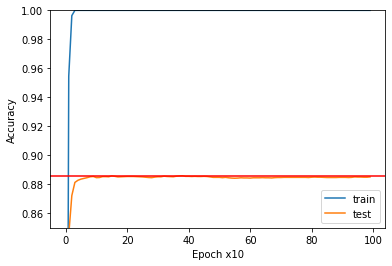

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(train_accuracy_values, label="train")
plt.plot(test_accuracy_values, label="test")
plt.ylabel('Accuracy')
plt.xlabel('Epoch x10')
plt.ylim([0.85, 1.0])
plt.axhline(y=max(test_accuracy_values), color='r', linestyle='-')
plt.legend(loc='lower right')
plt.show()

학습이 많이 진행될 수록 Test Accuracy가 오히려 약간 줄어드는 현상을 발견할 수 있었습니다. Loss 관점에서 바라보면 Overfitting 현상을 더 적나라하게 확인할 수 있습니다. 

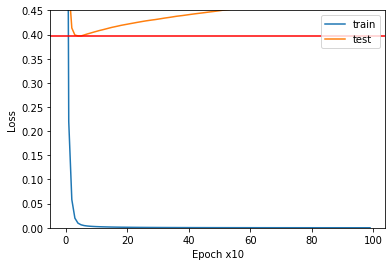

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_loss_values, label="train")
plt.plot(test_loss_values, label="test")
plt.ylabel('Loss')
plt.xlabel('Epoch x10')
plt.axhline(y=min(test_loss_values), color='r', linestyle='-')
plt.ylim([0, 0.45])
plt.legend(loc='upper right')
plt.show()

우리는 380번째 Epoch에서 가장 좋은 성능(88.59%)을 나타냄을 확인할 수 있었습니다. 우리는 이 모델의 성능을 88.59% 라고 할 수는 없습니다. 왜냐하면, 현실에서는 Test Accuracy를 사전에 알 수 없기 때문입니다. Training 데이터만을 이용해서 최적 Epoch을 찾고, 최적 Epoch에서의 Test Accuracy를 리포트해야 Fair하게 네트워크의 성능을 이야기할 수 있습니다. 다음 [실습](01_02_early_stop.ipynb)에서는 우리는 최적의 Epoch을 자동으로 찾을 수 있는 **Early Stop**에 대해서 배우고자 합니다. 